Suggested Bin width: 0.00608364310378425
Suggested Number of bins: 14
Optimal Lognormal parameters: shape (sigma) = 0.007, scale = 1.010, R² = 0.820


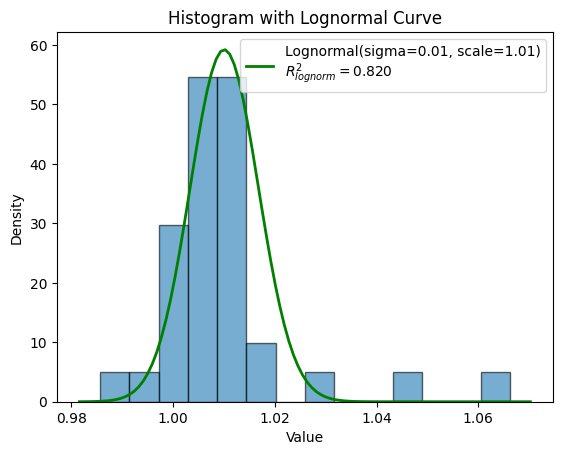


Expected value (Lognormal): 1.0101
99% Confidence error from expected value: ±0.0031 or ±0.31% of the Expected Value


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import lognorm, t
import math

# 14500 RPM Head
# Sample data – replace this list with your actual data (with outliers removed)
data = [1.0152,0.9952,1.0002,1.0662,1.0094,1.0084,1.0018,1.0101,1.0142,1.0130,0.9993,1.0031,1.0090,1.0046,1.0086,1.0129,1.0078,1.0034,1.0283,1.0114,1.0469,1.0029,1.0201,1.0135,0.9999,1.0033,1.0082,0.9856,0.9995,1.0011,1.0074,1.0121,1.0101,1.0136,1.0070]

# Calculate statistics for the Freedman-Diaconis rule for binning
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)
data = np.array(data)
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, _ = plt.hist(data, bins=num_bins, density=True,
                                alpha=0.6, edgecolor='black')

# Compute bin centers from the bin edges.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# For reference, compute the sample mean and sample standard deviation.
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# --- Lognormal Distribution Fit via Iterative (Ternary) Search on Shape (sigma) ---
# We force loc=0. To have the expected value match the sample mean, we set:
#    scale = sample_mean / exp(shape^2/2)
# Then, for any candidate shape, the predicted lognormal PDF is:
#    lognorm.pdf(x, shape, loc=0, scale)
#
# Define a function that returns R² and the corresponding scale for a given shape.
def lognorm_r2(shape, bin_centers, observed, sample_mean):
    # Force the expected value to be the sample mean:
    scale_candidate = sample_mean / np.exp(shape**2 / 2)
    # Compute predicted PDF at the bin centers.
    predicted = lognorm.pdf(bin_centers, shape, loc=0, scale=scale_candidate)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale_candidate

# Set a search interval for the shape parameter.
shape_low = 0.0001
shape_high = 5
tol = 1e-4  # tolerance for the search

# Ternary search loop (a variant of binary search for unimodal functions)
while shape_high - shape_low > tol:
    shape_mid1 = shape_low + (shape_high - shape_low) / 3
    shape_mid2 = shape_high - (shape_high - shape_low) / 3
    r2_mid1, scale_mid1 = lognorm_r2(shape_mid1, bin_centers, counts, sample_mean)
    r2_mid2, scale_mid2 = lognorm_r2(shape_mid2, bin_centers, counts, sample_mean)
    if r2_mid1 < r2_mid2:
        shape_low = shape_mid1
    else:
        shape_high = shape_mid2

optimal_shape = (shape_low + shape_high) / 2
optimal_r2, optimal_scale = lognorm_r2(optimal_shape, bin_centers, counts, sample_mean)
print(f"Optimal Lognormal parameters: shape (sigma) = {optimal_shape:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the lognormal PDF curve using the optimal parameters.
x_lognorm = np.linspace(xmin, xmax, 100)
pdf_lognorm = lognorm.pdf(x_lognorm, optimal_shape, loc=0, scale=optimal_scale)

# Plot the lognormal distribution curve.
plt.plot(x_lognorm, pdf_lognorm, 'g', linewidth=2,
         label=f'Lognormal(sigma={optimal_shape:.2f}, scale={optimal_scale:.2f})\n$R^2_{{lognorm}} = {optimal_r2:.3f}$')
plt.title("Histogram with Lognormal Curve")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Lognormal Distribution ---
# For a lognormal distribution with loc=0, the expected value is:
#    E[X] = scale * exp(shape^2 / 2)
expected_value_lognorm = optimal_scale * np.exp(optimal_shape**2 / 2)
# (By construction, this equals the sample mean, but we compute it model-based.)

# The variance for a lognormal is:
#    Var[X] = scale^2 * exp(shape^2) * (exp(shape^2) - 1)
variance_lognorm = optimal_scale**2 * np.exp(optimal_shape**2) * (np.exp(optimal_shape**2) - 1)

# Standard error of the mean (using model-based variance) is:
std_error_lognorm = np.sqrt(variance_lognorm) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_lognorm = expected_value_lognorm - t_crit * std_error_lognorm
ci_upper_lognorm = expected_value_lognorm + t_crit * std_error_lognorm

print(f"\nExpected value (Lognormal): {expected_value_lognorm:.4f}")
print(f"99% Confidence error from expected value: ±{t_crit * std_error_lognorm:.4f} "
      f"or ±{t_crit * std_error_lognorm/expected_value_lognorm*100:.2f}% of the Expected Value")

Suggested Bin width: 0.004157665638767184
Suggested Number of bins: 9
Optimal Lognormal parameters: shape (sigma) = 0.006, scale = 0.977, R² = 0.921


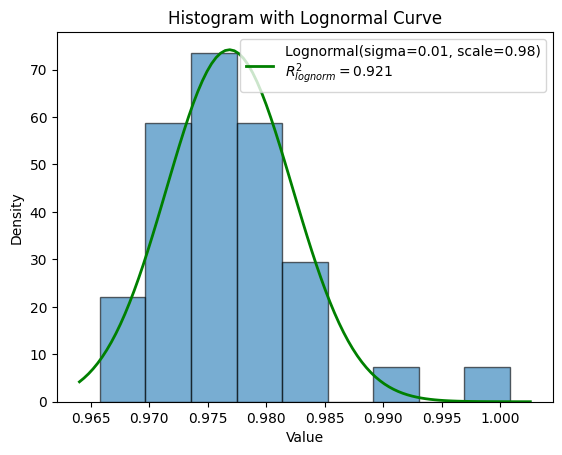


Expected value (Lognormal): 0.9769
99% Confidence error from expected value: ±0.0025 or ±0.25% of the Expected Value


In [22]:
# 14500 RPM Power
# Sample data - replace this list with your actual data
data = [0.9803,0.9742,0.9760,1.0008,0.9745,0.9726,0.9717,0.9771,0.9782,0.9805,0.9705,0.9715,0.9776,0.9735,0.9782,0.9814,0.9757,0.9725,0.9849,0.9781,0.9901,0.9761,0.9824,0.9813,0.9696,0.9759,0.9793,0.9658,0.9728,0.9683,0.9747,0.9756,0.9750,0.9817,0.9732]

# Calculate statistics for the Freedman-Diaconis rule for binning
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)
data = np.array(data)
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, _ = plt.hist(data, bins=num_bins, density=True,
                                alpha=0.6, edgecolor='black')

# Compute bin centers from the bin edges.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# For reference, compute the sample mean and sample standard deviation.
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# --- Lognormal Distribution Fit via Iterative (Ternary) Search on Shape (sigma) ---
# We force loc=0. To have the expected value match the sample mean, we set:
#    scale = sample_mean / exp(shape^2/2)
# Then, for any candidate shape, the predicted lognormal PDF is:
#    lognorm.pdf(x, shape, loc=0, scale)
#
# Define a function that returns R² and the corresponding scale for a given shape.
def lognorm_r2(shape, bin_centers, observed, sample_mean):
    # Force the expected value to be the sample mean:
    scale_candidate = sample_mean / np.exp(shape**2 / 2)
    # Compute predicted PDF at the bin centers.
    predicted = lognorm.pdf(bin_centers, shape, loc=0, scale=scale_candidate)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale_candidate

# Set a search interval for the shape parameter.
shape_low = 0.0001
shape_high = 20
tol = 1e-4  # tolerance for the search

# Ternary search loop (a variant of binary search for unimodal functions)
while shape_high - shape_low > tol:
    shape_mid1 = shape_low + (shape_high - shape_low) / 3
    shape_mid2 = shape_high - (shape_high - shape_low) / 3
    r2_mid1, scale_mid1 = lognorm_r2(shape_mid1, bin_centers, counts, sample_mean)
    r2_mid2, scale_mid2 = lognorm_r2(shape_mid2, bin_centers, counts, sample_mean)
    if r2_mid1 < r2_mid2:
        shape_low = shape_mid1
    else:
        shape_high = shape_mid2

optimal_shape = (shape_low + shape_high) / 2
optimal_r2, optimal_scale = lognorm_r2(optimal_shape, bin_centers, counts, sample_mean)
print(f"Optimal Lognormal parameters: shape (sigma) = {optimal_shape:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the lognormal PDF curve using the optimal parameters.
x_lognorm = np.linspace(xmin, xmax, 100)
pdf_lognorm = lognorm.pdf(x_lognorm, optimal_shape, loc=0, scale=optimal_scale)

# Plot the lognormal distribution curve.
plt.plot(x_lognorm, pdf_lognorm, 'g', linewidth=2,
         label=f'Lognormal(sigma={optimal_shape:.2f}, scale={optimal_scale:.2f})\n$R^2_{{lognorm}} = {optimal_r2:.3f}$')
plt.title("Histogram with Lognormal Curve")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Lognormal Distribution ---
# For a lognormal distribution with loc=0, the expected value is:
#    E[X] = scale * exp(shape^2 / 2)
expected_value_lognorm = optimal_scale * np.exp(optimal_shape**2 / 2)
# (By construction, this equals the sample mean, but we compute it model-based.)

# The variance for a lognormal is:
#    Var[X] = scale^2 * exp(shape^2) * (exp(shape^2) - 1)
variance_lognorm = optimal_scale**2 * np.exp(optimal_shape**2) * (np.exp(optimal_shape**2) - 1)

# Standard error of the mean (using model-based variance) is:
std_error_lognorm = np.sqrt(variance_lognorm) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_lognorm = expected_value_lognorm - t_crit * std_error_lognorm
ci_upper_lognorm = expected_value_lognorm + t_crit * std_error_lognorm

print(f"\nExpected value (Lognormal): {expected_value_lognorm:.4f}")
print(f"99% Confidence error from expected value: ±{t_crit * std_error_lognorm:.4f} "
      f"or ±{t_crit * std_error_lognorm/expected_value_lognorm*100:.2f}% of the Expected Value")

Suggested Bin width: 0.009538174112465752
Suggested Number of bins: 9
Optimal Lognormal parameters: shape (sigma) = 0.013, scale = 1.095, R² = 0.571


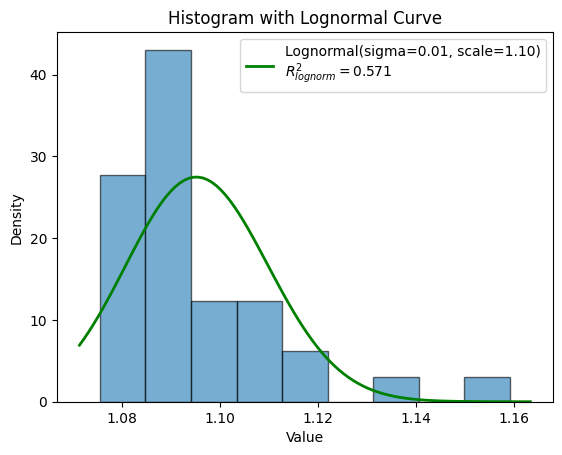


Expected value (Lognormal): 1.0956
99% Confidence error from expected value: ±0.0067 or ±0.61% of the Expected Value


In [18]:
# 15000 RPM Head
# Sample data - replace this list with your actual data
data = [1.0823,1.0889,1.1112,1.1592,1.0790,1.0963,1.0902,1.1127,1.0931,1.0859,1.0914,1.0994,1.1166,1.0910,1.0878,1.0847,1.0831,1.1357,1.0836,1.0833,1.1024,1.1070,1.1150,1.0900,1.0903,1.0902,1.0783,1.0927,1.1061,1.0809,1.0869,1.0756,1.0976,1.0867,1.0893]

# Calculate statistics for the Freedman-Diaconis rule for binning
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)
data = np.array(data)
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, _ = plt.hist(data, bins=num_bins, density=True,
                                alpha=0.6, edgecolor='black')

# Compute bin centers from the bin edges.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# For reference, compute the sample mean and sample standard deviation.
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# --- Lognormal Distribution Fit via Iterative (Ternary) Search on Shape (sigma) ---
# We force loc=0. To have the expected value match the sample mean, we set:
#    scale = sample_mean / exp(shape^2/2)
# Then, for any candidate shape, the predicted lognormal PDF is:
#    lognorm.pdf(x, shape, loc=0, scale)
#
# Define a function that returns R² and the corresponding scale for a given shape.
def lognorm_r2(shape, bin_centers, observed, sample_mean):
    # Force the expected value to be the sample mean:
    scale_candidate = sample_mean / np.exp(shape**2 / 2)
    # Compute predicted PDF at the bin centers.
    predicted = lognorm.pdf(bin_centers, shape, loc=0, scale=scale_candidate)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale_candidate

# Set a search interval for the shape parameter.
shape_low = 0.00001
shape_high = 10
tol = 1e-4  # tolerance for the search

# Ternary search loop (a variant of binary search for unimodal functions)
while shape_high - shape_low > tol:
    shape_mid1 = shape_low + (shape_high - shape_low) / 3
    shape_mid2 = shape_high - (shape_high - shape_low) / 3
    r2_mid1, scale_mid1 = lognorm_r2(shape_mid1, bin_centers, counts, sample_mean)
    r2_mid2, scale_mid2 = lognorm_r2(shape_mid2, bin_centers, counts, sample_mean)
    if r2_mid1 < r2_mid2:
        shape_low = shape_mid1
    else:
        shape_high = shape_mid2

optimal_shape = (shape_low + shape_high) / 2
optimal_r2, optimal_scale = lognorm_r2(optimal_shape, bin_centers, counts, sample_mean)
print(f"Optimal Lognormal parameters: shape (sigma) = {optimal_shape:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the lognormal PDF curve using the optimal parameters.
x_lognorm = np.linspace(xmin, xmax, 100)
pdf_lognorm = lognorm.pdf(x_lognorm, optimal_shape, loc=0, scale=optimal_scale)

# Plot the lognormal distribution curve.
plt.plot(x_lognorm, pdf_lognorm, 'g', linewidth=2,
         label=f'Lognormal(sigma={optimal_shape:.2f}, scale={optimal_scale:.2f})\n$R^2_{{lognorm}} = {optimal_r2:.3f}$')
plt.title("Histogram with Lognormal Curve")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Lognormal Distribution ---
# For a lognormal distribution with loc=0, the expected value is:
#    E[X] = scale * exp(shape^2 / 2)
expected_value_lognorm = optimal_scale * np.exp(optimal_shape**2 / 2)
# (By construction, this equals the sample mean, but we compute it model-based.)

# The variance for a lognormal is:
#    Var[X] = scale^2 * exp(shape^2) * (exp(shape^2) - 1)
variance_lognorm = optimal_scale**2 * np.exp(optimal_shape**2) * (np.exp(optimal_shape**2) - 1)

# Standard error of the mean (using model-based variance) is:
std_error_lognorm = np.sqrt(variance_lognorm) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_lognorm = expected_value_lognorm - t_crit * std_error_lognorm
ci_upper_lognorm = expected_value_lognorm + t_crit * std_error_lognorm

print(f"\nExpected value (Lognormal): {expected_value_lognorm:.4f}")
print(f"99% Confidence error from expected value: ±{t_crit * std_error_lognorm:.4f} "
      f"or ±{t_crit * std_error_lognorm/expected_value_lognorm*100:.2f}% of the Expected Value")


Suggested Bin width: 0.004707944914486374
Suggested Number of bins: 9
Optimal Lognormal parameters: shape (sigma) = 0.005, scale = 1.096, R² = 0.780


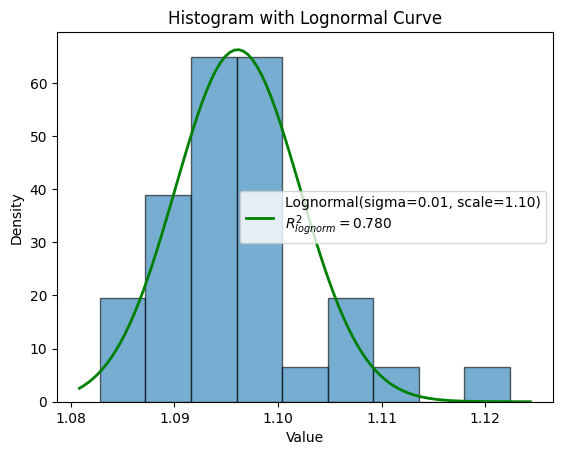


Expected value (Lognormal): 1.0961
99% Confidence error from expected value: ±0.0028 or ±0.25% of the Expected Value


In [19]:
# 15000 RPM Power
# Sample data - replace this list with your actual data
data = [1.0893,1.0973,1.0993,1.1224,1.0828,1.0951,1.0991,1.0997,1.0967,1.0916,1.0964,1.0959,1.1029,1.0883,1.0955,1.0950,1.0861,1.1062,1.0935,1.0935,1.0980,1.1054,1.1102,1.0923,1.0918,1.0902,1.0886,1.0933,1.1080,1.0867,1.0907,1.0914,1.0996,1.0962,1.0960]

# Calculate statistics for the Freedman-Diaconis rule for binning
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)
data = np.array(data)
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, _ = plt.hist(data, bins=num_bins, density=True,
                                alpha=0.6, edgecolor='black')

# Compute bin centers from the bin edges.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# For reference, compute the sample mean and sample standard deviation.
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# --- Lognormal Distribution Fit via Iterative (Ternary) Search on Shape (sigma) ---
# We force loc=0. To have the expected value match the sample mean, we set:
#    scale = sample_mean / exp(shape^2/2)
# Then, for any candidate shape, the predicted lognormal PDF is:
#    lognorm.pdf(x, shape, loc=0, scale)
#
# Define a function that returns R² and the corresponding scale for a given shape.
def lognorm_r2(shape, bin_centers, observed, sample_mean):
    # Force the expected value to be the sample mean:
    scale_candidate = sample_mean / np.exp(shape**2 / 2)
    # Compute predicted PDF at the bin centers.
    predicted = lognorm.pdf(bin_centers, shape, loc=0, scale=scale_candidate)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale_candidate

# Set a search interval for the shape parameter.
shape_low = 0.0001
shape_high = 5
tol = 1e-4  # tolerance for the search

# Ternary search loop (a variant of binary search for unimodal functions)
while shape_high - shape_low > tol:
    shape_mid1 = shape_low + (shape_high - shape_low) / 3
    shape_mid2 = shape_high - (shape_high - shape_low) / 3
    r2_mid1, scale_mid1 = lognorm_r2(shape_mid1, bin_centers, counts, sample_mean)
    r2_mid2, scale_mid2 = lognorm_r2(shape_mid2, bin_centers, counts, sample_mean)
    if r2_mid1 < r2_mid2:
        shape_low = shape_mid1
    else:
        shape_high = shape_mid2

optimal_shape = (shape_low + shape_high) / 2
optimal_r2, optimal_scale = lognorm_r2(optimal_shape, bin_centers, counts, sample_mean)
print(f"Optimal Lognormal parameters: shape (sigma) = {optimal_shape:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the lognormal PDF curve using the optimal parameters.
x_lognorm = np.linspace(xmin, xmax, 100)
pdf_lognorm = lognorm.pdf(x_lognorm, optimal_shape, loc=0, scale=optimal_scale)

# Plot the lognormal distribution curve.
plt.plot(x_lognorm, pdf_lognorm, 'g', linewidth=2,
         label=f'Lognormal(sigma={optimal_shape:.2f}, scale={optimal_scale:.2f})\n$R^2_{{lognorm}} = {optimal_r2:.3f}$')
plt.title("Histogram with Lognormal Curve")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Lognormal Distribution ---
# For a lognormal distribution with loc=0, the expected value is:
#    E[X] = scale * exp(shape^2 / 2)
expected_value_lognorm = optimal_scale * np.exp(optimal_shape**2 / 2)
# (By construction, this equals the sample mean, but we compute it model-based.)

# The variance for a lognormal is:
#    Var[X] = scale^2 * exp(shape^2) * (exp(shape^2) - 1)
variance_lognorm = optimal_scale**2 * np.exp(optimal_shape**2) * (np.exp(optimal_shape**2) - 1)

# Standard error of the mean (using model-based variance) is:
std_error_lognorm = np.sqrt(variance_lognorm) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_lognorm = expected_value_lognorm - t_crit * std_error_lognorm
ci_upper_lognorm = expected_value_lognorm + t_crit * std_error_lognorm

print(f"\nExpected value (Lognormal): {expected_value_lognorm:.4f}")
print(f"99% Confidence error from expected value: ±{t_crit * std_error_lognorm:.4f} "
      f"or ±{t_crit * std_error_lognorm/expected_value_lognorm*100:.2f}% of the Expected Value")

Suggested Bin width: 0.012918214455045929
Suggested Number of bins: 9
Optimal Lognormal parameters: shape (sigma) = 0.018, scale = 1.179, R² = 0.508


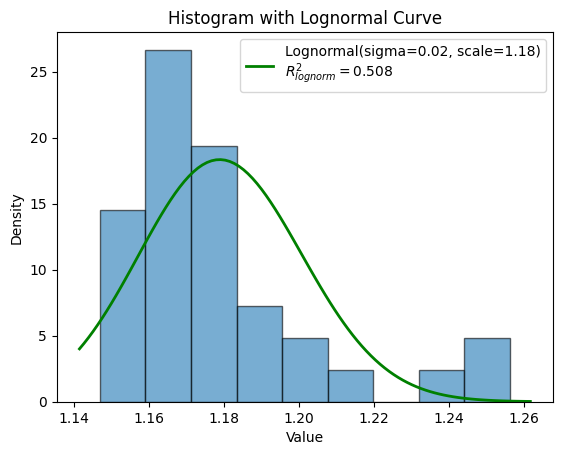


Expected value (Lognormal): 1.1795
99% Confidence error from expected value: ±0.0102 or ±0.86% of the Expected Value


In [20]:
# 15500 RPM Head
# Sample data - replace this list with your actual data
data = [1.1800,1.2562,1.1894,1.1582,1.1633,1.2504,1.1723,1.2180,1.1820,1.1534,1.1606,1.1649,1.1608,1.1576,1.1971,1.1704,1.1652,1.1737,1.2356,1.1814,1.1794,1.1631,1.1828,1.1680,1.1470,1.1645,1.1949,1.1570,1.1845,1.1687,1.1764,1.1539,1.2027,1.1690]

# Calculate statistics for the Freedman-Diaconis rule for binning
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)
data = np.array(data)
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, _ = plt.hist(data, bins=num_bins, density=True,
                                alpha=0.6, edgecolor='black')

# Compute bin centers from the bin edges.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# For reference, compute the sample mean and sample standard deviation.
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# --- Lognormal Distribution Fit via Iterative (Ternary) Search on Shape (sigma) ---
# We force loc=0. To have the expected value match the sample mean, we set:
#    scale = sample_mean / exp(shape^2/2)
# Then, for any candidate shape, the predicted lognormal PDF is:
#    lognorm.pdf(x, shape, loc=0, scale)
#
# Define a function that returns R² and the corresponding scale for a given shape.
def lognorm_r2(shape, bin_centers, observed, sample_mean):
    # Force the expected value to be the sample mean:
    scale_candidate = sample_mean / np.exp(shape**2 / 2)
    # Compute predicted PDF at the bin centers.
    predicted = lognorm.pdf(bin_centers, shape, loc=0, scale=scale_candidate)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale_candidate

# Set a search interval for the shape parameter.
shape_low = 0.0001
shape_high = 5
tol = 1e-4  # tolerance for the search

# Ternary search loop (a variant of binary search for unimodal functions)
while shape_high - shape_low > tol:
    shape_mid1 = shape_low + (shape_high - shape_low) / 3
    shape_mid2 = shape_high - (shape_high - shape_low) / 3
    r2_mid1, scale_mid1 = lognorm_r2(shape_mid1, bin_centers, counts, sample_mean)
    r2_mid2, scale_mid2 = lognorm_r2(shape_mid2, bin_centers, counts, sample_mean)
    if r2_mid1 < r2_mid2:
        shape_low = shape_mid1
    else:
        shape_high = shape_mid2

optimal_shape = (shape_low + shape_high) / 2
optimal_r2, optimal_scale = lognorm_r2(optimal_shape, bin_centers, counts, sample_mean)
print(f"Optimal Lognormal parameters: shape (sigma) = {optimal_shape:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the lognormal PDF curve using the optimal parameters.
x_lognorm = np.linspace(xmin, xmax, 100)
pdf_lognorm = lognorm.pdf(x_lognorm, optimal_shape, loc=0, scale=optimal_scale)

# Plot the lognormal distribution curve.
plt.plot(x_lognorm, pdf_lognorm, 'g', linewidth=2,
         label=f'Lognormal(sigma={optimal_shape:.2f}, scale={optimal_scale:.2f})\n$R^2_{{lognorm}} = {optimal_r2:.3f}$')
plt.title("Histogram with Lognormal Curve")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Lognormal Distribution ---
# For a lognormal distribution with loc=0, the expected value is:
#    E[X] = scale * exp(shape^2 / 2)
expected_value_lognorm = optimal_scale * np.exp(optimal_shape**2 / 2)
# (By construction, this equals the sample mean, but we compute it model-based.)

# The variance for a lognormal is:
#    Var[X] = scale^2 * exp(shape^2) * (exp(shape^2) - 1)
variance_lognorm = optimal_scale**2 * np.exp(optimal_shape**2) * (np.exp(optimal_shape**2) - 1)

# Standard error of the mean (using model-based variance) is:
std_error_lognorm = np.sqrt(variance_lognorm) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_lognorm = expected_value_lognorm - t_crit * std_error_lognorm
ci_upper_lognorm = expected_value_lognorm + t_crit * std_error_lognorm

print(f"\nExpected value (Lognormal): {expected_value_lognorm:.4f}")
print(f"99% Confidence error from expected value: ±{t_crit * std_error_lognorm:.4f} "
      f"or ±{t_crit * std_error_lognorm/expected_value_lognorm*100:.2f}% of the Expected Value")

Suggested Bin width: 0.008766482449780231
Suggested Number of bins: 6
Optimal Lognormal parameters: shape (sigma) = 0.011, scale = 1.185, R² = 0.507


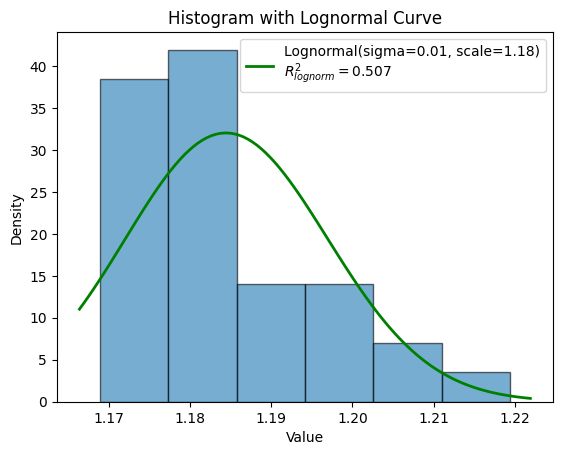


Expected value (Lognormal): 1.1846
99% Confidence error from expected value: ±0.0058 or ±0.49% of the Expected Value


In [21]:
# 15500 RPM Power
# Sample data - replace this list with your actual data
data = [1.1780,1.2194,1.1927,1.1731,1.1805,1.2080,1.1801,1.2095,1.1833,1.1736,1.1819,1.1802,1.1689,1.1772,1.1968,1.1795,1.1728,1.1865,1.1967,1.1767,1.1872,1.1821,1.1772,1.1828,1.1729,1.1809,1.1970,1.1759,1.1931,1.1847,1.1771,1.1792,1.1947,1.1770]

# Calculate statistics for the Freedman-Diaconis rule for binning
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)
data = np.array(data)
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, _ = plt.hist(data, bins=num_bins, density=True,
                                alpha=0.6, edgecolor='black')

# Compute bin centers from the bin edges.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# For reference, compute the sample mean and sample standard deviation.
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# --- Lognormal Distribution Fit via Iterative (Ternary) Search on Shape (sigma) ---
# We force loc=0. To have the expected value match the sample mean, we set:
#    scale = sample_mean / exp(shape^2/2)
# Then, for any candidate shape, the predicted lognormal PDF is:
#    lognorm.pdf(x, shape, loc=0, scale)
#
# Define a function that returns R² and the corresponding scale for a given shape.
def lognorm_r2(shape, bin_centers, observed, sample_mean):
    # Force the expected value to be the sample mean:
    scale_candidate = sample_mean / np.exp(shape**2 / 2)
    # Compute predicted PDF at the bin centers.
    predicted = lognorm.pdf(bin_centers, shape, loc=0, scale=scale_candidate)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale_candidate

# Set a search interval for the shape parameter.
shape_low = 0.0001
shape_high = 5
tol = 1e-4  # tolerance for the search

# Ternary search loop (a variant of binary search for unimodal functions)
while shape_high - shape_low > tol:
    shape_mid1 = shape_low + (shape_high - shape_low) / 3
    shape_mid2 = shape_high - (shape_high - shape_low) / 3
    r2_mid1, scale_mid1 = lognorm_r2(shape_mid1, bin_centers, counts, sample_mean)
    r2_mid2, scale_mid2 = lognorm_r2(shape_mid2, bin_centers, counts, sample_mean)
    if r2_mid1 < r2_mid2:
        shape_low = shape_mid1
    else:
        shape_high = shape_mid2

optimal_shape = (shape_low + shape_high) / 2
optimal_r2, optimal_scale = lognorm_r2(optimal_shape, bin_centers, counts, sample_mean)
print(f"Optimal Lognormal parameters: shape (sigma) = {optimal_shape:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the lognormal PDF curve using the optimal parameters.
x_lognorm = np.linspace(xmin, xmax, 100)
pdf_lognorm = lognorm.pdf(x_lognorm, optimal_shape, loc=0, scale=optimal_scale)

# Plot the lognormal distribution curve.
plt.plot(x_lognorm, pdf_lognorm, 'g', linewidth=2,
         label=f'Lognormal(sigma={optimal_shape:.2f}, scale={optimal_scale:.2f})\n$R^2_{{lognorm}} = {optimal_r2:.3f}$')
plt.title("Histogram with Lognormal Curve")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Lognormal Distribution ---
# For a lognormal distribution with loc=0, the expected value is:
#    E[X] = scale * exp(shape^2 / 2)
expected_value_lognorm = optimal_scale * np.exp(optimal_shape**2 / 2)
# (By construction, this equals the sample mean, but we compute it model-based.)

# The variance for a lognormal is:
#    Var[X] = scale^2 * exp(shape^2) * (exp(shape^2) - 1)
variance_lognorm = optimal_scale**2 * np.exp(optimal_shape**2) * (np.exp(optimal_shape**2) - 1)

# Standard error of the mean (using model-based variance) is:
std_error_lognorm = np.sqrt(variance_lognorm) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_lognorm = expected_value_lognorm - t_crit * std_error_lognorm
ci_upper_lognorm = expected_value_lognorm + t_crit * std_error_lognorm

print(f"\nExpected value (Lognormal): {expected_value_lognorm:.4f}")
print(f"99% Confidence error from expected value: ±{t_crit * std_error_lognorm:.4f} "
      f"or ±{t_crit * std_error_lognorm/expected_value_lognorm*100:.2f}% of the Expected Value")